✅ Conectado a CoppeliaSim
Trayectoria generada con 1200 puntos
🚀 Iniciando seguimiento de trayectoria...
Paso 0: pos=(-0.876, -0.625), objetivo=(0.000, 0.000), error_dist=1.076, error_ang=0.620
Paso 20: pos=(-0.629, -0.509), objetivo=(0.200, 0.000), error_dist=0.973, error_ang=-0.011
Paso 40: pos=(-0.351, -0.348), objetivo=(0.400, 0.000), error_dist=0.827, error_ang=-0.021
Paso 60: pos=(-0.056, -0.219), objetivo=(0.600, 0.000), error_dist=0.692, error_ang=-0.021
Paso 80: pos=(0.236, -0.127), objetivo=(0.800, 0.000), error_dist=0.578, error_ang=-0.017
Paso 100: pos=(0.552, -0.062), objetivo=(1.000, 0.000), error_dist=0.452, error_ang=-0.014
Paso 120: pos=(0.872, -0.022), objetivo=(1.200, 0.000), error_dist=0.329, error_ang=-0.011
Paso 140: pos=(1.185, -0.004), objetivo=(1.400, 0.000), error_dist=0.215, error_ang=-0.008
Paso 160: pos=(1.498, 0.000), objetivo=(1.600, 0.000), error_dist=0.102, error_ang=-0.003
Paso 180: pos=(1.738, 0.000), objetivo=(1.800, 0.000), error_dist=0.062, error_a

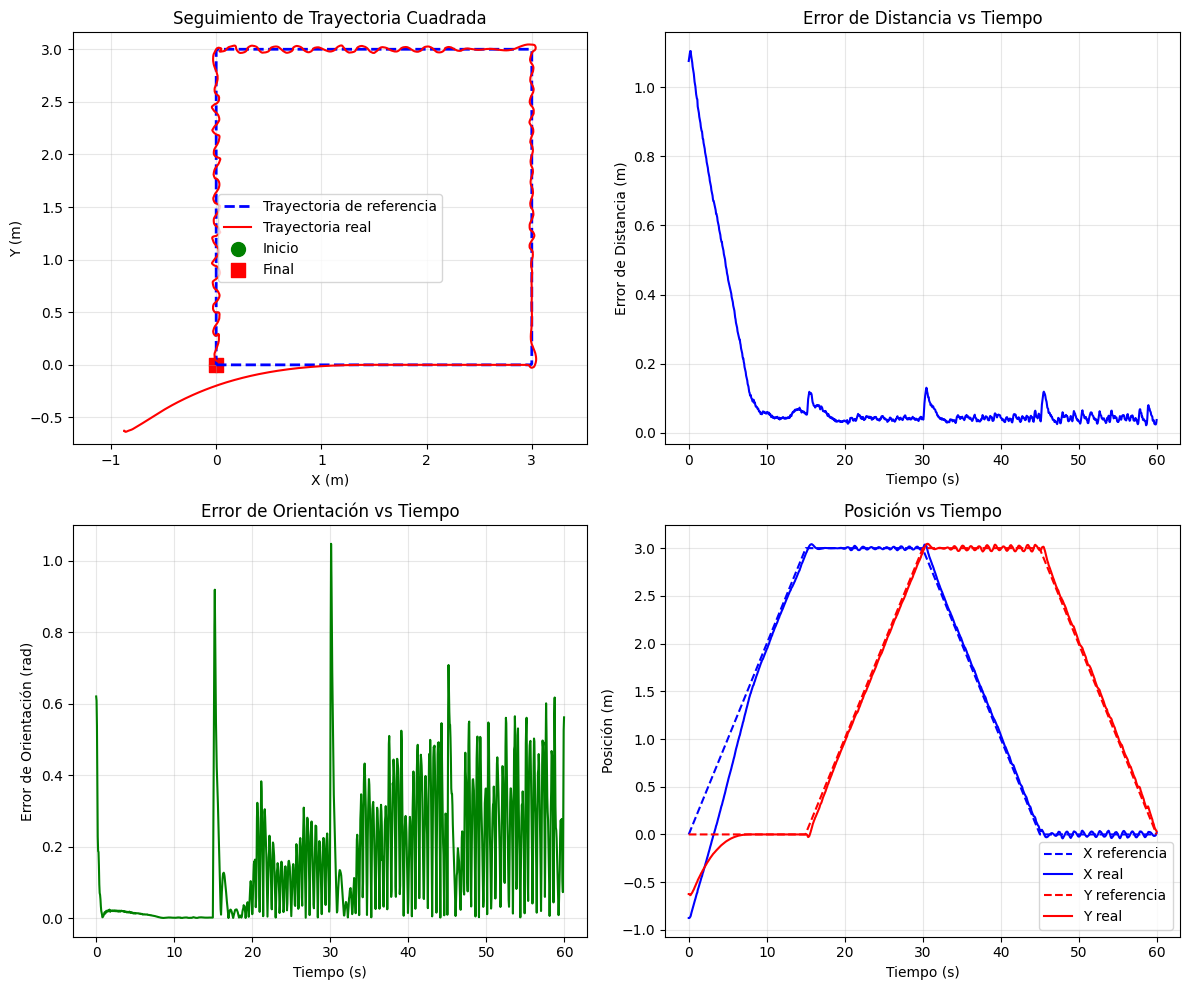


📊 Métricas de Rendimiento:
Error medio de distancia: 0.1203 m
Error máximo de distancia: 1.1047 m
Error final de distancia: 0.0371 m
🔌 Conexión cerrada


In [ ]:
import sim
import time
import numpy as np
import matplotlib.pyplot as plt

class TrayectoriaGeometrica:

    def __init__(self,precision):
        pass
    def lineal(self,x0,y0,x1,y1):
        pass

    def circular(self,x,y,r):
        pass

    def rectangular(self,x0,y0,x1,y1):
        pass



class PIDController:
    def __init__(self, kp, ki, kd, dt=0.05):
        self.kp = kp  # Ganancia proporcional
        self.ki = ki  # Ganancia integral
        self.kd = kd  # Ganancia derivativa
        self.dt = dt  # Tiempo de muestreo
        
        # Variables internas del PID
        self.prev_error = 0.0
        self.integral = 0.0
        
    def compute(self, error):
        """Calcula la salida del controlador PID"""
        # Término proporcional
        proportional = self.kp * error
        
        # Término integral
        self.integral += error * self.dt
        integral_term = self.ki * self.integral
        
        # Término derivativo
        derivative = (error - self.prev_error) / self.dt
        derivative_term = self.kd * derivative
        
        # Salida total del PID
        output = proportional + integral_term + derivative_term
        
        # Actualizar error previo
        self.prev_error = error
        
        return output
    
    def reset(self):
        """Reinicia los términos integral y derivativo"""
        self.prev_error = 0.0
        self.integral = 0.0

def trayectoriaPID(L, A, velTrayectoria):
    """Genera trayectoria cuadrada"""
    NptosLargo = round(L / (velTrayectoria * 0.1))
    NptosAncho = round(A / (velTrayectoria * 0.1))
    compx1 = np.linspace(0, L, NptosLargo)
    compy1 = np.linspace(0, A, NptosAncho)
    inx = compx1[1] - compx1[0]
    iny = compy1[1] - compy1[0]
    x1 = np.linspace(0, L - inx, NptosLargo)
    y1 = np.zeros_like(x1)
    y2 = np.linspace(iny, A - iny, NptosAncho)
    x2 = L * np.ones_like(y2)
    x3 = np.linspace(L - inx, inx, NptosLargo)
    y3 = A * np.ones_like(x3)
    y4 = np.linspace(A - iny, 0, NptosAncho)
    x4 = np.zeros_like(y4)
    xref = np.concatenate([x1, x2, x3, x4])
    yref = np.concatenate([y1, y2, y3, y4])
    return xref, yref

def connect_to_coppelia():
    """Establece conexión con CoppeliaSim"""
    sim.simxFinish(-1)  # Cierra conexiones previas
    client_id = sim.simxStart('127.0.0.1', 19997, True, True, 5000, 5)
    if client_id != -1:
        print("✅ Conectado a CoppeliaSim")
    else:
        raise Exception("❌ No se pudo conectar")
    return client_id

def get_handles(client_id):
    """Obtiene los handles de los objetos del robot"""
    _, left_motor = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx_leftMotor', sim.simx_opmode_blocking)
    _, right_motor = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx_rightMotor', sim.simx_opmode_blocking)
    _, robot = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx', sim.simx_opmode_blocking)
    return left_motor, right_motor, robot

def get_robot_position(client_id, handle):
    """Obtiene posición y orientación del robot"""
    _, position = sim.simxGetObjectPosition(client_id, handle, -1, sim.simx_opmode_buffer)
    _, orientation = sim.simxGetObjectOrientation(client_id, handle, -1, sim.simx_opmode_buffer)
    return position, orientation

def set_motor_speeds(client_id, left_motor, right_motor, v_l, v_r):
    """Establece velocidades de los motores"""
    sim.simxSetJointTargetVelocity(client_id, left_motor, v_l, sim.simx_opmode_oneshot)
    sim.simxSetJointTargetVelocity(client_id, right_motor, v_r, sim.simx_opmode_oneshot)

def normalize_angle(angle):
    """Normaliza ángulo entre -π y π"""
    return np.arctan2(np.sin(angle), np.cos(angle))

def pid_trajectory_following(client_id, robot, left_motor, right_motor, xref, yref):
    """Implementa seguimiento de trayectoria con controlador PID"""
    
    # Parámetros del robot Pioneer P3-DX
    L = 0.381  # distancia entre ruedas [m]
    r = 0.0975  # radio de las ruedas [m]
    
    # Parámetros del controlador PID
    # PID para control de posición (distancia)
    pid_distance = PIDController(kp=0.46, ki=0.008, kd=0.08)
    # PID para control de orientación
    pid_orientation = PIDController(kp=1.8, ki=0.045, kd=0.18)
    
    # Inicializar streaming de datos
    sim.simxGetObjectPosition(client_id, robot, -1, sim.simx_opmode_streaming)
    sim.simxGetObjectOrientation(client_id, robot, -1, sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Variables para almacenar datos
    trajectory_data = {
        'time': [],
        'x_actual': [],
        'y_actual': [],
        'x_ref': [],
        'y_ref': [],
        'error_distance': [],
        'error_orientation': []
    }
    
    dt = 0.05  # Tiempo de muestreo
    max_velocity = 0.1  # Velocidad máxima
    
    print("🚀 Iniciando seguimiento de trayectoria...")
    
    for i, (x_target, y_target) in enumerate(zip(xref, yref)):
        start_time = time.time()
        
        # Obtener posición actual del robot
        pos, orient = get_robot_position(client_id, robot)
        x_actual, y_actual = pos[0], pos[1]
        theta_actual = orient[2]  # orientación en Z (yaw)
        
        # Calcular errores
        dx = x_target - x_actual
        dy = y_target - y_actual
        distance_error = np.sqrt(dx**2 + dy**2)
        
        # Ángulo deseado hacia el objetivo
        theta_desired = np.arctan2(dy, dx)
        orientation_error = normalize_angle(theta_desired - theta_actual)
        
        # Aplicar controladores PID
        velocity_command = pid_distance.compute(distance_error)
        angular_velocity_command = pid_orientation.compute(orientation_error)
        
        # Limitar velocidades
        velocity_command = np.clip(velocity_command, 0, max_velocity)
        angular_velocity_command = np.clip(angular_velocity_command, -2.0, 2.0)
        
        # Reducir velocidad lineal si error angular es grande
        if abs(orientation_error) > 0.5:
            velocity_command *= 0.3
        
        # Cinemática inversa para calcular velocidades de ruedas
        v_left = (velocity_command - (L/2) * angular_velocity_command) / r
        v_right = (velocity_command + (L/2) * angular_velocity_command) / r
        
        # Aplicar velocidades a los motores
        set_motor_speeds(client_id, left_motor, right_motor, v_left, v_right)
        
        # Almacenar datos para análisis
        current_time = i * dt
        trajectory_data['time'].append(current_time)
        trajectory_data['x_actual'].append(x_actual)
        trajectory_data['y_actual'].append(y_actual)
        trajectory_data['x_ref'].append(x_target)
        trajectory_data['y_ref'].append(y_target)
        trajectory_data['error_distance'].append(distance_error)
        trajectory_data['error_orientation'].append(abs(orientation_error))
        
        # Información de depuración
        if i % 20 == 0:  # Mostrar cada 20 iteraciones
            print(f"Paso {i}: pos=({x_actual:.3f}, {y_actual:.3f}), "
                  f"objetivo=({x_target:.3f}, {y_target:.3f}), "
                  f"error_dist={distance_error:.3f}, error_ang={orientation_error:.3f}")
        
        # Mantener frecuencia de control
        elapsed = time.time() - start_time
        if elapsed < dt:
            time.sleep(dt - elapsed)
    
    # Detener robot al final
    set_motor_speeds(client_id, left_motor, right_motor, 0, 0)
    print("✅ Trayectoria completada")
    
    return trajectory_data

def plot_results(trajectory_data, xref, yref):
    """Genera gráficos de análisis del seguimiento"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Gráfico 1: Trayectoria en el plano XY
    ax1.plot(xref, yref, 'b--', linewidth=2, label='Trayectoria de referencia')
    ax1.plot(trajectory_data['x_actual'], trajectory_data['y_actual'], 'r-', linewidth=1.5, label='Trayectoria real')
    ax1.scatter(xref[0], yref[0], color='green', s=100, marker='o', label='Inicio')
    ax1.scatter(xref[-1], yref[-1], color='red', s=100, marker='s', label='Final')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Seguimiento de Trayectoria Cuadrada')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # Gráfico 2: Error de distancia vs tiempo
    ax2.plot(trajectory_data['time'], trajectory_data['error_distance'], 'b-', linewidth=1.5)
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Error de Distancia (m)')
    ax2.set_title('Error de Distancia vs Tiempo')
    ax2.grid(True, alpha=0.3)
    
    # Gráfico 3: Error de orientación vs tiempo
    ax3.plot(trajectory_data['time'], trajectory_data['error_orientation'], 'g-', linewidth=1.5)
    ax3.set_xlabel('Tiempo (s)')
    ax3.set_ylabel('Error de Orientación (rad)')
    ax3.set_title('Error de Orientación vs Tiempo')
    ax3.grid(True, alpha=0.3)
    
    # Gráfico 4: Posición X e Y vs tiempo
    ax4.plot(trajectory_data['time'], trajectory_data['x_ref'], 'b--', label='X referencia')
    ax4.plot(trajectory_data['time'], trajectory_data['x_actual'], 'b-', label='X real')
    ax4.plot(trajectory_data['time'], trajectory_data['y_ref'], 'r--', label='Y referencia')
    ax4.plot(trajectory_data['time'], trajectory_data['y_actual'], 'r-', label='Y real')
    ax4.set_xlabel('Tiempo (s)')
    ax4.set_ylabel('Posición (m)')
    ax4.set_title('Posición vs Tiempo')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calcular métricas de rendimiento
    error_medio = np.mean(trajectory_data['error_distance'])
    error_max = np.max(trajectory_data['error_distance'])
    error_final = trajectory_data['error_distance'][-1]
    
    print("\n📊 Métricas de Rendimiento:")
    print(f"Error medio de distancia: {error_medio:.4f} m")
    print(f"Error máximo de distancia: {error_max:.4f} m")
    print(f"Error final de distancia: {error_final:.4f} m")

def main():
    """Función principal"""
    try:
        # Conectar a CoppeliaSim
        client_id = connect_to_coppelia()
        
        # Iniciar simulación
        sim.simxStartSimulation(client_id, sim.simx_opmode_oneshot)
        time.sleep(1)
        
        # Obtener handles
        left_motor, right_motor, robot = get_handles(client_id)
        
        # Generar trayectoria cuadrada de 3x3 metros
        L = 3.0  # Largo del cuadrado [m]
        A = 3.0  # Ancho del cuadrado [m]
        velTrayectoria = 0.1  # Velocidad de la trayectoria [m/s]
        
        xref, yref = trayectoriaPID(L, A, velTrayectoria)
        print(f"Trayectoria generada con {len(xref)} puntos")
        
        # Ejecutar seguimiento de trayectoria con PID
        trajectory_data = pid_trajectory_following(client_id, robot, left_motor, right_motor, xref, yref)
        
        # Generar gráficos de análisis
        plot_results(trajectory_data, xref, yref)
        
    except Exception as e:
        print(f"❌ Error: {e}")
    
    finally:
        # Limpiar y cerrar conexión
        try:
            sim.simxStopSimulation(client_id, sim.simx_opmode_blocking)
            time.sleep(1)
            sim.simxFinish(client_id)
            print("🔌 Conexión cerrada")
        except:
            pass

if __name__ == "__main__":
    main()

✅ Conectado a CoppeliaSim
Trayectoria generada con 1200 puntos
🚀 Iniciando seguimiento de trayectoria con control Fuzzy...
Paso 0: pos=(2.174, 2.125), objetivo=(0.000, 0.000), error_dist=3.040, error_ang=-2.367
Paso 20: pos=(2.200, 2.090), objetivo=(0.200, 0.000), error_dist=2.893, error_ang=3.009
Paso 40: pos=(2.208, 2.082), objetivo=(0.400, 0.000), error_dist=2.757, error_ang=2.921
Paso 60: pos=(2.156, 2.078), objetivo=(0.600, 0.000), error_dist=2.596, error_ang=-2.681
Paso 80: pos=(2.192, 2.088), objetivo=(0.800, 0.000), error_dist=2.510, error_ang=-2.972
Paso 100: pos=(2.240, 2.107), objetivo=(1.000, 0.000), error_dist=2.444, error_ang=2.658
Paso 120: pos=(2.214, 2.101), objetivo=(1.200, 0.000), error_dist=2.334, error_ang=-3.021
Paso 140: pos=(2.203, 2.091), objetivo=(1.400, 0.000), error_dist=2.240, error_ang=-2.785
Paso 160: pos=(2.254, 2.120), objetivo=(1.600, 0.000), error_dist=2.219, error_ang=2.762
Paso 180: pos=(2.255, 2.118), objetivo=(1.800, 0.000), error_dist=2.166, erro

KeyboardInterrupt: 